In [ ]:
import cv2
import numpy as np
from PIL import Image
import sys
def estimate_noise(image: Image.Image):
    img = np.array(image.convert("L"))
    mean = np.mean(img)
    std = np.std(img)
    snr = mean / (std + 1e-8)
    return {"mean": mean, "std": std, "snr": snr}


In [ ]:
def brightness_contrast(image: Image.Image):
    gray = np.array(image.convert("L"))
    brightness = np.mean(gray)
    contrast = np.std(gray)
    return {"brightness": brightness, "contrast": contrast}


In [ ]:
def sharpness(image: Image.Image):
    img = np.array(image.convert("L"))
    lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return {"sharpness": lap_var}
    

In [ ]:
def analyze_image(image: Image.Image):
    """Trả về tất cả thông số ảnh"""
    return {
        "Noise": estimate_noise(image),
        "Brightness & Contrast": brightness_contrast(image),
        "Sharpness": sharpness(image)
    }

In [ ]:
from PIL import Image

if __name__ == "__main__":
    # Đường dẫn ảnh cố định
    path = r"C:\Users\ASUS\BData Intern\n6_ocrmedical\Requirement\data\ket-qua-sieu-am.png"   # đổi thành tên ảnh bạn muốn

    image = Image.open(path)

    results = analyze_image(image)

    print("📊 Kết quả phân tích ảnh:")
    for k, v in results.items():
        print(f"{k}: {v}")


In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
# ====== Hàm chính ======
def process_image(image: Image.Image):
    img = np.array(image.convert("RGB"))

    analysis = analyze_image(image)
    brightness = analysis["Brightness & Contrast"]["brightness"]
    contrast = analysis["Brightness & Contrast"]["contrast"]
    snr = analysis["Noise"]["snr"]
    sharpness = analysis["Sharpness"]["sharpness"]

    # 1. Noise
    if snr < 5:  
        img = denoise(img)

    # 2. Brightness
    if brightness < 100:
        img = adjust_brightness(img, 1.3)
    elif brightness > 180:
        img = adjust_brightness(img, 0.7)

    # 3. Contrast
    if contrast < 40:
        img = adjust_contrast(img, 1.4)
    elif contrast > 80:
        img = adjust_contrast(img, 0.8)

    # 4. Sharpness
    if sharpness < 300:
        img = adjust_sharpness(img, 2.0)
    elif sharpness > 2000:
        img = adjust_sharpness(img, 0.5)

    return Image.fromarray(img)


In [ ]:
img = Image.open(r"C:\Users\ASUS\BData Intern\n6_ocrmedical\Requirement\data\ket-qua-sieu-am.png")
result = process_image(img)
result.save("output.jpg")


Danh sách ảnh trong thư mục data/:
0: GRV.jpg
1: KPT.jpg
2: NoiKhoa_Yen.webp
3: QDan.jpg
4: SieuAm.webp
5: TA_ThaoNhi.png
6: TV_ThimHuong.jpg

>> Đang chọn: SieuAm.webp

=== QUALITY REPORT ===

[TRƯỚC XỬ LÝ]
- Contrast : 54.67
- SNR      : 3.039
- Sharpness: 1216.71

Ảnh này có vấn đề gì?
👉 SNR = 3.04 < 8 → Khử nhiễu
👉 Tương phản ổn
👉 Sharpness thấp (1216.7) → tăng nét (x2.47)

[SAU XỬ LÝ]
- Contrast : 58.74
- SNR      : 2.827
- Sharpness: 4477.74

Saved:
- D:\Workspace\Intern_Bdata\n6_ocrmedical\output\SieuAm_orig.png
- D:\Workspace\Intern_Bdata\n6_ocrmedical\output\SieuAm_processed.png


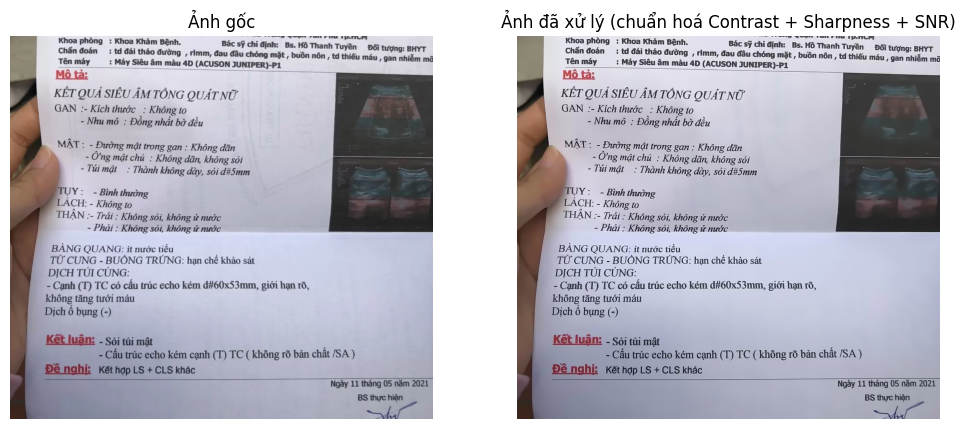

In [18]:
# =========================
# 0) IMPORTS & SETUP
# =========================
import os
from pathlib import Path
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

# Đường dẫn (chỉnh nếu khác)
DATA_DIR = Path(r"D:\Workspace\Intern_Bdata\n6_ocrmedical\data")
OUT_DIR = Path(r"D:\Workspace\Intern_Bdata\n6_ocrmedical\output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp")

# =========================
# 1) HÀM PHÂN TÍCH CHẤT LƯỢNG
# =========================
def analyze_image(pil_img: Image.Image):
    """Trả về các chỉ số: contrast, snr, sharpness (không brightness)."""
    rgb = np.array(pil_img.convert("RGB"))
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    contrast = float(gray.std())                 # Độ tương phản
    eps = 1e-6
    snr = float((gray.mean() + eps) / (gray.std() + eps))  # SNR
    sharpness = float(cv2.Laplacian(gray, cv2.CV_64F).var())  # Độ nét

    return {
        "Contrast": contrast,
        "Noise": snr,
        "Sharpness": sharpness
    }

# =========================
# 2) HÀM XỬ LÝ ẢNH
# =========================
def denoise(img_bgr: np.ndarray):
    """Khử nhiễu bằng fastNlMeans + bilateral filter."""
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    y_dn = cv2.fastNlMeansDenoising(y, h=7, templateWindowSize=7, searchWindowSize=21)
    ycrcb_dn = cv2.merge([y_dn, cr, cb])
    bgr_dn = cv2.cvtColor(ycrcb_dn, cv2.COLOR_YCrCb2BGR)
    bgr_dn = cv2.bilateralFilter(bgr_dn, d=5, sigmaColor=50, sigmaSpace=50)
    return bgr_dn

def adjust_contrast(img_bgr: np.ndarray, factor: float):
    """Điều chỉnh tương phản."""
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    enhancer = ImageEnhance.Contrast(pil)
    pil_adj = enhancer.enhance(factor)
    return cv2.cvtColor(np.array(pil_adj), cv2.COLOR_RGB2BGR)

def adjust_sharpness(img_bgr: np.ndarray, factor: float):
    """Điều chỉnh độ sắc nét."""
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    enhancer = ImageEnhance.Sharpness(pil)
    pil_adj = enhancer.enhance(factor)
    return cv2.cvtColor(np.array(pil_adj), cv2.COLOR_RGB2BGR)

# =========================
# 3) PIPELINE KHÔNG BRIGHTNESS
# =========================
def process_image_with_report(pil_image: Image.Image):
    img_bgr = cv2.cvtColor(np.array(pil_image.convert("RGB")), cv2.COLOR_RGB2BGR)

    analysis = analyze_image(pil_image)
    contrast = analysis["Contrast"]
    snr = analysis["Noise"]
    sharpness = analysis["Sharpness"]

    # Ngưỡng mục tiêu
    target = {
        "contrast": (50, 60),
        "snr": 8,             # min
        "sharpness": (3000, 4000)
    }

    actions = []

    # ---- 1. Noise (SNR) ----
    if snr < target["snr"]:
        img_bgr = denoise(img_bgr)
        actions.append(f"SNR = {snr:.2f} < {target['snr']} → Khử nhiễu")
    else:
        actions.append("Nhiễu ổn")

    # ---- 2. Contrast ----
    if contrast < target["contrast"][0]:
        factor = target["contrast"][0] / (contrast + 1e-6)
        img_bgr = adjust_contrast(img_bgr, factor)
        actions.append(f"Contrast thấp ({contrast:.1f}) → tăng contrast (x{factor:.2f})")
    elif contrast > target["contrast"][1]:
        factor = target["contrast"][1] / (contrast + 1e-6)
        img_bgr = adjust_contrast(img_bgr, factor)
        actions.append(f"Contrast cao ({contrast:.1f}) → giảm contrast (x{factor:.2f})")
    else:
        actions.append("Tương phản ổn")

    # ---- 3. Sharpness ----
    if sharpness < target["sharpness"][0]:
        factor = target["sharpness"][0] / (sharpness + 1e-6)
        img_bgr = adjust_sharpness(img_bgr, factor)
        actions.append(f"Sharpness thấp ({sharpness:.1f}) → tăng nét (x{factor:.2f})")
    elif sharpness > target["sharpness"][1]:
        factor = target["sharpness"][1] / (sharpness + 1e-6)
        img_bgr = adjust_sharpness(img_bgr, factor)
        actions.append(f"Sharpness cao ({sharpness:.1f}) → làm mềm (x{factor:.2f})")
    else:
        actions.append("Độ nét ổn")

    # ---- Phân tích lại sau xử lý ----
    processed_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    analysis_after = analyze_image(processed_pil)

    report = {"before": analysis, "after": analysis_after, "actions": actions}
    return pil_image, processed_pil, report

# =========================
# 4) CHỌN ẢNH THEO SỐ
# =========================
img_files = [p for p in DATA_DIR.glob("*") if p.suffix.lower() in IMG_EXTS]
if not img_files:
    raise FileNotFoundError(f"Không tìm thấy ảnh trong thư mục: {DATA_DIR.resolve()}")

print("Danh sách ảnh trong thư mục data/:")
for i, p in enumerate(sorted(img_files)):
    print(f"{i}: {p.name}")

idx = int(input("\nNhập số ảnh muốn chọn: "))
if idx < 0 or idx >= len(img_files):
    raise ValueError("Số nhập không hợp lệ!")

chosen_path = sorted(img_files)[idx]
print(f"\n>> Đang chọn: {chosen_path.name}")

pil_input = Image.open(chosen_path)

# =========================
# 5) XỬ LÝ & IN REPORT
# =========================
orig_pil, proc_pil, rpt = process_image_with_report(pil_input)

print("\n=== QUALITY REPORT ===")
print("\n[TRƯỚC XỬ LÝ]")
print(f"- Contrast : {rpt['before']['Contrast']:.2f}")
print(f"- SNR      : {rpt['before']['Noise']:.3f}")
print(f"- Sharpness: {rpt['before']['Sharpness']:.2f}")

print("\nẢnh này có vấn đề gì?")
for act in rpt["actions"]:
    print("👉", act)

print("\n[SAU XỬ LÝ]")
print(f"- Contrast : {rpt['after']['Contrast']:.2f}")
print(f"- SNR      : {rpt['after']['Noise']:.3f}")
print(f"- Sharpness: {rpt['after']['Sharpness']:.2f}")

# =========================
# 6) LƯU FILE
# =========================
out_orig = OUT_DIR / f"{chosen_path.stem}_orig.png"
out_proc = OUT_DIR / f"{chosen_path.stem}_processed.png"
orig_pil.save(out_orig)
proc_pil.save(out_proc)
print(f"\nSaved:\n- {out_orig}\n- {out_proc}")

# =========================
# 7) HIỂN THỊ SONG SONG
# =========================
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(orig_pil)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(proc_pil)
plt.title("Ảnh đã xử lý (chuẩn hoá Contrast + Sharpness + SNR)")
plt.axis("off")

plt.show()
